In [2]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas
import contractions  # 약어 정규화에 필요한 라이브러리
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wlstj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wlstj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import urllib.request
import pandas as pd
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [5]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
data.dropna(axis=0, inplace=True)

In [7]:
import contractions

def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "html.parser").text  # 'lxml' 대신 'html.parser' 사용
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호로 닫힌 문자열 (...) 제거
    sentence = re.sub('"', '', sentence)  # 쌍따옴표 " 제거
    sentence = ' '.join([contractions.fix(t) for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s\b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상이면 2개로 변경
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if word not in stopwords.words('english') and len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens


In [8]:
clean_headlines = []

for text in data['headlines']:
    clean_headlines.append(preprocess_sentence(text, remove_stopwords=False))

C:\Users\wlstj\AppData\Local\Temp\ipykernel_7400\1743249797.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "html.parser").text  # 'lxml' 대신 'html.parser' 사용


In [9]:
clean_text = []

for text in data['text']:
    clean_text.append(preprocess_sentence(text))


In [10]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.dropna(axis=0, inplace=True)

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09384912566084
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.306364375762506


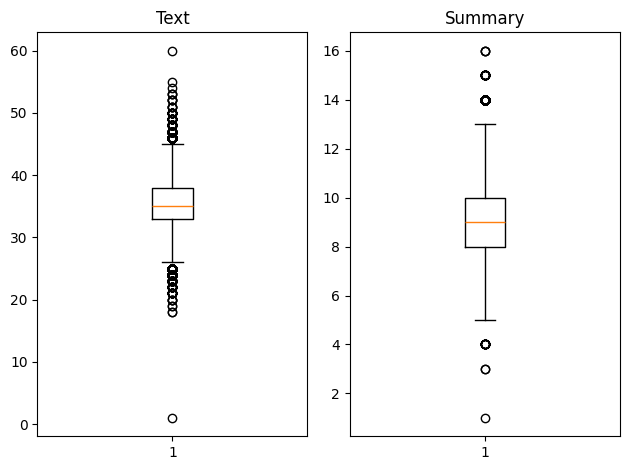

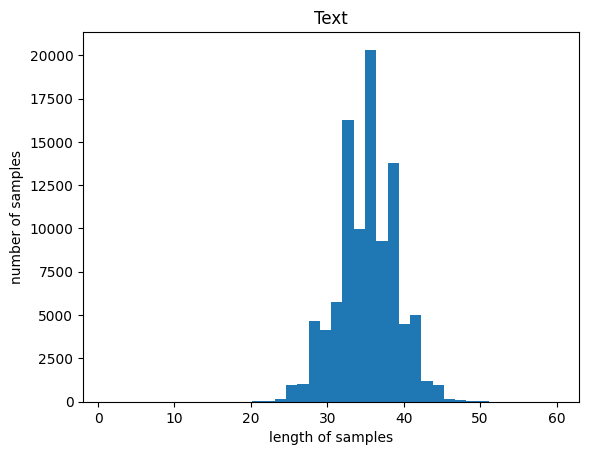

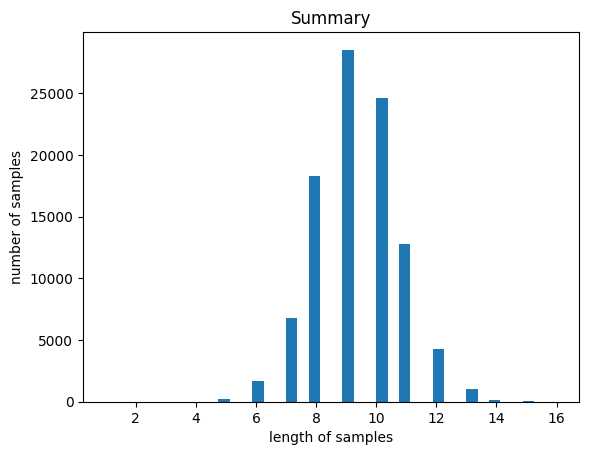

In [11]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


In [12]:
text_max_len = 42
headlines_max_len = 12

In [13]:
test_datat = data['text'].apply(lambda x: len(x.split()) < text_max_len)
test_datas = data['headlines'].apply(lambda x: len(x.split()) < headlines_max_len)
filtered_data = data[test_datat & test_datas]
print(len(filtered_data))
data = filtered_data

88679


In [14]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['text'].apply(lambda x : x + ' eostoken')

encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


In [15]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [16]:
threshold = 11
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65963
등장 빈도가 10번 이하인 희귀 단어의 수: 49494
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 16469
단어 집합에서 희귀 단어의 비율: 75.0329730303352
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.2382487927848995


In [17]:
src_vocab = 16500
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [18]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [19]:
threshold = 12
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28912
등장 빈도가 11번 이하인 희귀 단어의 수: 22474
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6438
단어 집합에서 희귀 단어의 비율: 77.73242944106254
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.924522708324924


In [20]:
tar_vocab = 6400
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 48, 93, 355, 166, 399, 113, 69, 968], [1, 100, 195, 133, 248, 486, 10, 4017, 1186], [1, 3028, 4391, 4, 185, 851, 754, 559], [1, 1622, 5539, 820, 60, 486, 4, 178, 4887, 59], [1, 6, 5593, 18, 3201, 435, 499, 1750, 89]]
target
decoder  [[48, 93, 67, 399, 69, 25, 158, 2514, 48, 668, 25, 166, 153, 771, 166, 386, 876, 865, 5520, 153, 126, 327, 166, 48, 25, 153, 166, 2839, 2], [1186, 174, 3, 266, 100, 195, 133, 1248, 486, 292, 3693, 3577, 182, 156, 523, 353, 182, 6253, 195, 133, 9, 1186, 3, 195, 133, 207, 1307, 2], [3028, 1782, 81, 29, 363, 311, 27, 26, 3028, 2324, 2704, 754, 559, 4391, 121, 1589, 945, 851, 754, 559, 141, 3028, 1095, 559, 1963, 358, 19, 402, 551, 376, 221, 221, 156, 1943, 1020, 240, 272, 2], [1142, 1970, 59, 5126, 5539, 107, 2585, 1728, 4887, 1414, 3409, 1487, 2251, 5539, 4887, 458, 5537, 5126, 5539, 107, 2759, 2585, 487, 34, 5539, 40, 45, 181, 28, 945, 2], [89, 81, 3, 6, 3796, 401, 3201, 499, 1750, 67, 512, 6, 2663, 512, 1066, 2051, 2605, 1460, 52, 2869, 29

In [21]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 70943
훈련 레이블의 개수 : 70943
테스트 데이터의 개수 : 17734
테스트 레이블의 개수 : 17734


In [22]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [101]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output, state_h, state_c = encoder_lstm3(encoder_output2)

In [102]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs,state_h, state_c   = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [103]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax', name='decoder_softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_softmax_outputs)

In [104]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 42, 128)   │  2,112,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 42, 256), │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 42, 256), │    525,312 │ lstm[0][0]        │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 128) │    819,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 42, 256), │    525,312 │ lstm_1[0][0]      │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │    394,240 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm_2[0][1],     │
│                     │ 256), (None,      │            │ lstm_2[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_3[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  3,283,200 │ concat_layer[0][… │
│                     │ 6400)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,053,760 (30.72 MB)

 Trainable params: 8,053,760 (30.72 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - loss: 7.6404 - val_loss: 7.2344
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 206s 742ms/step - loss: 7.2441 - val_loss: 7.2144
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 194s 699ms/step - loss: 7.2155 - val_loss: 7.2003
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 192s 691ms/step - loss: 7.2022 - val_loss: 7.1950
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 197s 708ms/step - loss: 7.1938 - val_loss: 7.2019
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 191s 689ms/step - loss: 7.1848 - val_loss: 7.1925
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 191s 688ms/step - loss: 7.1764 - val_loss: 7.1928
Epoch 8/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 190s 684ms/step - loss: 7.1738 - val_loss: 7.1924
Epoch 9/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 191s 688ms/step - loss: 7.1758 - val_loss: 7.1954
Epoch 10/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 191s 688ms/step - loss: 7.1982 - val_loss: 7.1885
Epoch 11/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 191s 688ms/step - loss: 7.1708 - val_loss: 7.1813
Epoch 12/50

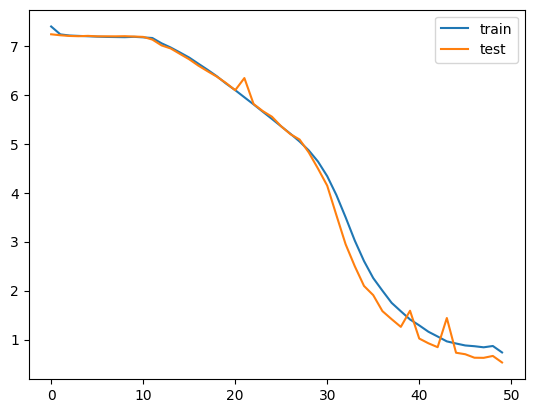

In [106]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [107]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

=3


In [27]:
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 하이퍼파라미터
embedding_dim = 128
hidden_size = 256


# 인코더 설계
encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
encoder_output, state_h, state_c = encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.5)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 어텐션 레이어
attn_layer = AdditiveAttention(name='attention_layer')
attn_out = attn_layer([decoder_outputs, encoder_output])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax', name='decoder_softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_softmax_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

# 모델 학습
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(
    [encoder_input_train, decoder_input_train], 
    decoder_target_train, 
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), 
    batch_size=512, 
    callbacks=[es], 
    epochs=50
)

# 인코더 모델 정의
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output, state_h, state_c])

# 디코더 모델 정의
decoder_state_input_h = Input(shape=(hidden_size,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(hidden_size,), name='decoder_state_input_c')
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
attn_out_inf = attn_layer([decoder_outputs2, encoder_output])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs, encoder_output, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)

# 디코딩 함수
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index.get('sostoken', 0)  # <SOS> 토큰의 인덱스
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word.get(sampled_token_index, '')
        
        if sampled_token != 'eostoken':
            decoded_sentence += ' ' + sampled_token
        
        if sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (headlines_max_len - 1):
            stop_condition = True
        
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

# 텍스트 변환 함수
def seq2text(input_seq):
    return ' '.join([src_index_to_word.get(i, '') for i in input_seq if i != 0])

# 요약문 변환 함수
def seq2summary(input_seq):
    return ' '.join([tar_index_to_word.get(i, '') for i in input_seq if i != 0])

# 결과 출력
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, -1)))
    print("\n")


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 42, 128)   │  2,112,000 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ [(None, 42, 256), │    394,240 │ embedding_8[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ [(None, 42, 256), │    525,312 │ lstm_16[0][0]     │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, None, 128) │    819,200 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ [(None, 42, 256), │    525,312 │ lstm_17[0][0]     │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ [(None, None,     │    394,240 │ embedding_9[0][0… │
│                     │ 256), (None,      │            │ lstm_18[0][1],    │
│                     │ 256), (None,      │            │ lstm_18[0][2]     │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, None, 256) │        256 │ lstm_19[0][0],    │
│ (AdditiveAttention) │                   │            │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_layer        │ (None, None, 512) │          0 │ lstm_19[0][0],    │
│ (Concatenate)       │                   │            │ attention_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_softmax     │ (None, None,      │  3,283,200 │ concat_layer[0][… │
│ (Dense)             │ 6400)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,053,760 (30.72 MB)

 Trainable params: 8,053,760 (30.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


KeyboardInterrupt: 

In [117]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0):  # 0은 패딩 값을 나타내는 경우가 많으므로 제외
            temp = temp + tar_index_to_word[i] + ' '
    return temp


for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : hyderabad ranked city highest quality living among indian cities per quality living index however hyderabad slipped five spots global rankings new delhi continued ranked lowest among indian cities list second straight year 
실제 요약 : sostoken hyderabad indian city with highest quality of living survey 


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2672415067312\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 42), dtype=int32)\n  • training=False\n  • mask=None'

In [114]:
import requests
from summa.summarizer import summarize
for i in range(50, 100):
    print('Summary:')
    print(summarize(seq2text(encoder_input_test[i]), ratio=0.005))

    print('Summary:')
    print(summarize(seq2text(encoder_input_test[i]), ratio=0.005, split=True))

    print('Summary:')
    print(summarize(seq2text(encoder_input_test[i]), words=50))

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary:

Summary:
[]
Summary:

Summary: